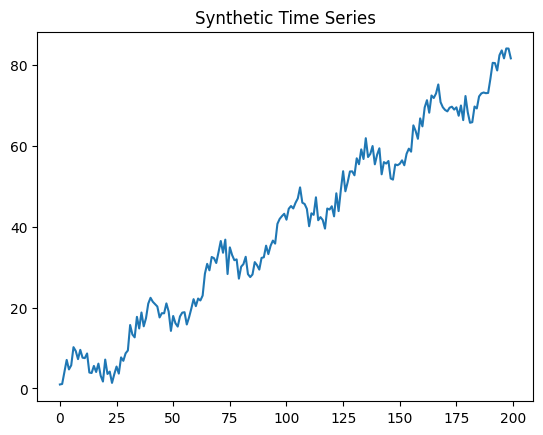

C:\Users\Sarmita\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


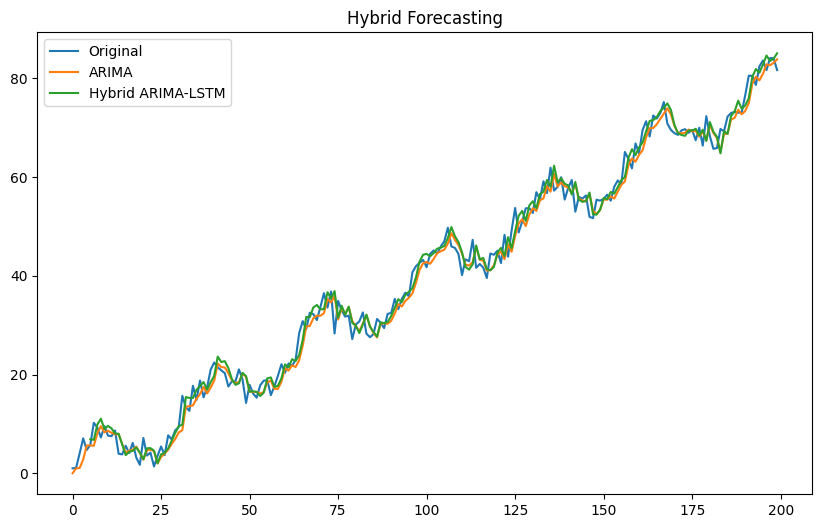

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Synthetic series with trend + seasonality + noise
np.random.seed(42)
time = np.arange(200)
series = 0.4*time + 5*np.sin(0.2*time) + np.random.normal(scale=2, size=200)

plt.plot(time, series); plt.title("Synthetic Time Series"); plt.show()

# Step 1: ARIMA
arima_fit = ARIMA(series, order=(2,1,2)).fit()
residuals = arima_fit.resid

# Step 2: LSTM on residuals
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.reshape(-1,1))

X, y = [], []
for i in range(5, len(residuals_scaled)):
    X.append(residuals_scaled[i-5:i,0])
    y.append(residuals_scaled[i,0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1],1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, verbose=0)

pred_residuals = scaler.inverse_transform(model.predict(X, verbose=0))
hybrid_forecast = arima_fit.fittedvalues[5:] + pred_residuals.flatten()

plt.figure(figsize=(10,6))
plt.plot(series, label="Original")
plt.plot(arima_fit.fittedvalues, label="ARIMA")
plt.plot(range(5,len(hybrid_forecast)+5), hybrid_forecast, label="Hybrid ARIMA-LSTM")
plt.legend(); plt.title("Hybrid Forecasting"); plt.show()
